In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import operator
import matplotlib.pyplot as plt
import json
from pathlib import Path

dataset_filename = Path("../train_data/arithmetic__mixed.txt")

In [2]:
# Helper functions to read data

from pathlib import Path
import re
import numpy as np

def ps(s):
    """Process String: convert a string into a list of lowercased words."""
    return [word.strip() for word in re.split(r'([+-/*()?]|\d|\w)', s) if word.strip()]

def read_data(filepath,perc_data,max_q_len,max_a_len):
    '''
    returns character lists of questions and answers.
    '''
    # q,a lists
    X = []
    y = []
    file_len = 0
    
    with open(filepath) as f:
        # Grabbing a subset of the entire file
        lines = f.readlines()
        file_len = len(lines)
        
    with open(filepath) as dataset_file:
        for i in range(0,int(file_len*perc_data)):
            line_q = dataset_file.readline().strip()
            line_a = dataset_file.readline().strip()
            if(len(line_q) < max_q_len and len(line_a) < max_a_len):
                X.append(ps(line_q))
                y.append(ps(line_a))   
    return X,y

def pad_data(X,y, max_question_len, max_answer_len):
    # dataset is of form [(q,a)]
    X_padded = list()
    for q in X:
        qpad =  ['BOE'] + q + ['EOE'] + ['#' for _ in range(max_question_len-len(q))] 
        X_padded.append(qpad)
    y_padded = list()
    for a in y:
        apad =  ['BOE']  + a + ['EOE'] + ['#' for _ in range(max_answer_len-len(a))]
        y_padded.append(apad)
    return X_padded,y_padded

In [3]:
def create_alphabet_index(X):

    char_to_int = {}
    char_to_int['#'] = 0
    for q in X:
        for word in q:
            if word not in char_to_int:
                char_to_int[word] = len(char_to_int)
    
    int_to_char = dict([(char_to_int[char],char) for char in char_to_int])

    return (char_to_int,int_to_char)

def encode_data(X,y,char_to_int):
    Xenc = list()
    
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    yenc = list()
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    
    return Xenc, yenc

# one hot encode
def one_hot_encode(X, y, vocab_size):
	Xenc = list()
	for seq in X:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(vocab_size)]
			vector[index] = 1
			pattern.append(vector)
		Xenc.append(pattern)
	yenc = list()
	for seq in y:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(vocab_size)]
			vector[index] = 1
			pattern.append(vector)
		yenc.append(pattern)
	return Xenc, yenc

def one_hot_decode(seq, int_to_char):
	strings = list()
	for pattern in seq:
		string = int_to_char[np.argmax(pattern)]
		strings.append(string)
	return ''.join(strings)

def process_data(dataset_filename, perc_data,max_q_len,max_a_len):
    X,y = read_data(dataset_filename,perc_data,max_q_len,max_a_len)
    X,y = pad_data(X,y,max_q_len,max_a_len)
    X_train,X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2)
    char_to_int,int_to_char = create_alphabet_index(X_train)
    X_train,y_train = encode_data(X_train,y_train,char_to_int)
    X_test,y_test = encode_data(X_test,y_test,char_to_int)
    # X,y = one_hot_encode(X,y,len(char_to_int))
    return (X_train, y_train, X_test,y_test,char_to_int,int_to_char)

In [4]:
def try_experiment(trial,i):
    
    n_batch =  trial["n_batch"]
    n_epoch =  trial["n_epoch"]
    data_perc = trial["data_perc"]
    embed_dim = trial["embed_dim"]
    encoder_hid = trial["encoder_hid"]
    decoder_hid = trial["decoder_hid"]
    max_q_len = trial["max_q_len"]
    max_a_len = trial["max_a_len"]
    
    X_train,y_train,X_test,y_test, char_to_int,int_to_char = process_data(dataset_filename, data_perc,max_q_len,max_a_len)

    model = Sequential()
    model.add(Embedding(len(char_to_int), embed_dim, input_length=max_q_len+2, mask_zero = True))
    model.add(LSTM(encoder_hid, input_shape=(max_q_len+2, len(char_to_int))))
    model.add(RepeatVector(max_a_len+2))
    model.add(LSTM(decoder_hid, return_sequences=True))
    model.add(TimeDistributed(Dense(len(char_to_int), activation='softmax'))),
    checkpoint_filepath = Path("../tmp/checkpoint/{:d}.ckpt".format(i))
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    print(model.summary())

    _, y_train = one_hot_encode([],y_train, len(char_to_int))
    _, y_test = one_hot_encode([],y_test,len(char_to_int))
    # train LSTM
    history = model.fit(np.array(X_train), np.array(y_train), validation_data=(X_test, y_test),
                        epochs=n_epoch, batch_size=n_batch, callbacks=[early_stop_callback,model_checkpoint_callback])
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("figs/acc/trial_{:d}_acc.png".format(i))
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("figs/loss/trial_{:d}_loss.png".format(i))
    plt.show()
    js = {
        "parameters": trial,
         "history": history.history
    }

    with open("json/trial_{:d}.json".format(i), "w") as outfile:
        json.dump(js, outfile)

In [5]:
def create_trials():
    trials = []
    data_percs = [0.1,0.5]
    n_batchs = [128]
    n_epochs =  [100]
    embed_dims = [30,100]
    encoder_hids = [128,256]
    decoder_hids = [128,256]
    max_lens = [(20,5),(30,10)]
    for d_h in decoder_hids:
        for n_b in n_batchs:   
            for e_h in encoder_hids: 
                for e_d in embed_dims: 
                    for n_e in n_epochs:
                        for m_l in max_lens:
                            for p in data_percs:
                                trials.append(
                                    {
                                        "n_batch" :  n_b,
                                        "n_epoch" :  n_e,
                                        "data_perc" : p,
                                        "embed_dim" : e_d,
                                        "encoder_hid" : e_h,
                                        "decoder_hid" : d_h,
                                        "max_q_len" : m_l[0],
                                        "max_a_len" : m_l[1]   
                                    })
    return trials

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 22, 30)            1020      
                                                                 
 lstm_2 (LSTM)               (None, 256)               293888    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 7, 256)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 7, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 34)            4386      
 tributed)                                                       
                                                                 
Total params: 496,414
Trainable params: 496,414
Non-tr

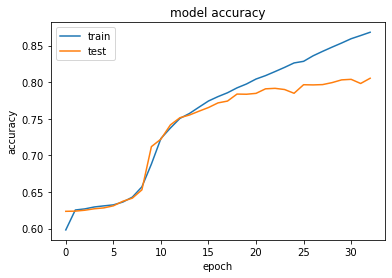

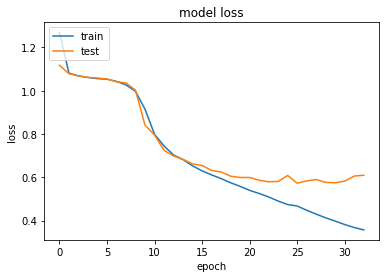

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 30)            1080      
                                                                 
 lstm_4 (LSTM)               (None, 256)               293888    
                                                                 
 repeat_vector_2 (RepeatVect  (None, 12, 256)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 12, 128)           197120    
                                                                 
 time_distributed_2 (TimeDis  (None, 12, 36)           4644      
 tributed)                                                       
                                                                 
Total params: 496,732
Trainable params: 496,732
Non-tr

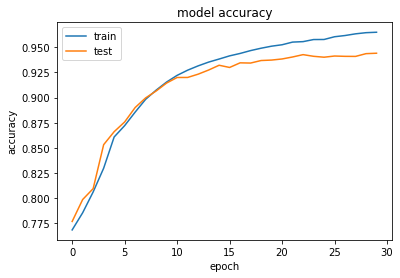

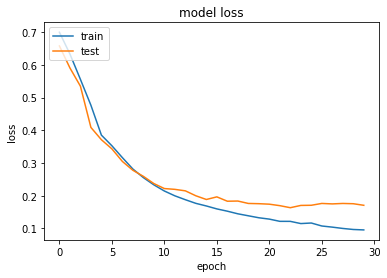

In [8]:
trials = [{"n_batch" :  128, "n_epoch" :  100, "data_perc" : 0.5,"embed_dim" : 30, 
               "encoder_hid" : 256,"decoder_hid" : 128, "max_q_len" : 20, "max_a_len" : 5},
             {"n_batch" :  128, "n_epoch" :  100, "data_perc" : 0.5,"embed_dim" : 30, 
               "encoder_hid" : 256,"decoder_hid" : 128, "max_q_len" : 30, "max_a_len" : 10}]
# or alternatively, create this manually: 
# trials.append({"n_batch" :  n_b, "n_epoch" :  n_e, "data_perc" : p,"embed_dim" : e_d, 
#               "encoder_hid" : e_h,"decoder_hid" : d_h, "max_q_len" : m_q_len, "max_a_len" : m_q_len})
# be careful not to overwrite existing files. Change i to i + 10 maybe if you already did 10 trials
for i,trial in enumerate(trials):
    try_experiment(trial,i+5)

In [39]:

    with open("json/trial_{:d}.json".format(6), "r") as outfile:
        trial = json.load(outfile)
    trial = trial["parameters"]
    n_batch =  trial["n_batch"]
    n_epoch =  trial["n_epoch"]
    data_perc = trial["data_perc"]
    embed_dim = trial["embed_dim"]
    encoder_hid = trial["encoder_hid"]
    decoder_hid = trial["decoder_hid"]
    max_q_len = trial["max_q_len"]
    max_a_len = trial["max_a_len"]
    #checkpoint_filepath = "./checkpoint_{:d}/{:d}.ckpt".format(trial_num,trial_num)
    
    X_train,y_train,X_test,y_test, char_to_int,int_to_char = process_data(dataset_filename, data_perc,max_q_len,max_a_len)
    model = Sequential()
    model.add(Embedding(len(char_to_int), embed_dim, input_length=max_q_len+2, mask_zero = True))
    model.add(LSTM(encoder_hid, input_shape=(max_q_len+2, len(char_to_int))))
    model.add(RepeatVector(max_a_len+2))
    model.add(LSTM(decoder_hid, return_sequences=True))
    model.add(TimeDistributed(Dense(len(char_to_int), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    print(model.summary())
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
    
    _, y_train = one_hot_encode([],y_train, len(char_to_int))
    _, y_test = one_hot_encode([],y_test,len(char_to_int))
    # train LSTM
    history = model.fit(np.array(X_train), np.array(y_train), validation_data=(X_test, y_test),
                        epochs=n_epoch, batch_size=n_batch,callbacks=[early_stop_callback])
    # evaluate on some new patterns
    result = model.predict(X_test[:1000], verbose=0)
    # calculate error
    expected = [one_hot_decode(x, int_to_char) for x in y_test[:1000]]
    predicted = [one_hot_decode(x, int_to_char) for x in result]
    # show some examples
    for i in range(1000):
        print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 32, 30)            1080      
                                                                 
 lstm_30 (LSTM)              (None, 256)               293888    
                                                                 
 repeat_vector_15 (RepeatVec  (None, 12, 256)          0         
 tor)                                                            
                                                                 
 lstm_31 (LSTM)              (None, 12, 128)           197120    
                                                                 
 time_distributed_15 (TimeDi  (None, 12, 36)           4644      
 stributed)                                                      
                                                                 
Total params: 496,732
Trainable params: 496,732
Non-t

KeyboardInterrupt: 